In [1]:
%%html 
<style>
.rendered_html code {
    padding: 2px 4px;
    font-size: 90%;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
}

.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

.rendered_html td {
    text-align: left;
}
span.text-strike {
    text-decoration: line-through;
}
span.text-red {
    color: red;
}
</style>

# Previsão da qualidade de vinhos

Este notebook visa explorar o dataset de vinhos para compreender como cada característica dos mesmos impactam em sua qualidade. Além disso, a qualidade do vinho será prevista a partir de tais características. Para isso, usaremos técnicas de aprendizado supervisionado. Este documento é dividido da seguinte forma:

* Análise exploratória dos dados
* Análise da relação entre as variáveis
* Pré processamento dos dados
* Implementação e análise do modelo
* Conclusões
* Referências 

As linhas de código abaixo apenas carregam o dataset em memória e definem algumas funções úteis para esse projeto. Faremos um pequeno ajuste no nome das colunas para que sigam o padrão _snake_case_ e _lower case_ (padrão "pythônico").

In [2]:
import pandas as pd
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
import re
import seaborn as sns
import helper

from scipy.stats import chi2_contingency
from __future__ import division
from tmcm_feature_engineering import TMCMFeatureEng
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.svm import SVC


def slugify(c):
    # make strnig lower case
    c = c.lower()
    # remove unused white spaces
    c = c.strip()
    # replace multiple spaces with one
    c = re.sub('\s+', ' ', c)
    # replace spaces with underscore
    c = c.replace(" ", "_")
    return(c)

df = pd.read_csv("data/winequality.csv", sep=";")

rename_dict = {}
for c in df.columns:
    old_c = c
    new_c = slugify(c)
    rename_dict[old_c] = new_c
    
df = df.rename(columns=rename_dict)

In [3]:
df.dtypes

type                     object
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
ph                      float64
sulphates               float64
alcohol                  object
quality                   int64
dtype: object

## Análise exploratória dos dados

Nesta seção exploraremos as características básicas do dataset, não apenas suas dimensões mas também as suas variáveis. O dataset contém 6497 linhas e 13 colunas nas quais cada linha representa um vinho diferente com suas características e apresenta as seguintes colunas:

* `type`: tipo do vinho (categórica)
* `fixed acidity`: acidez fixa (numérica)
* `volatile_acitidy`: acidez volátil (numérica)
* `citric_acid`: quantidade de ácido cítrico (numérica)
* `residual_sugar`: quantidade de açúcar residual (numérica)
* `chlorides`: quantidade de cloretos (numérica)
* `free_sulfur_dioxide`: quantidade de dióxido sulfúrico livre (numérica)
* `total_sulfur_dioxide`: quantidade total de dióxido sulfúrico (numérica)
* `density`: densidade do vinho (numérica)
* `ph`: potencial de hidrogênio do vinho, ou seja, o quanto ele é ácido ou básico (numérica)
* `sulphates`: quantiadde de sulfato no vinho (numérica)
* `alcohol`: quantidade de álcool no vinho (numérica)
* `quality`: qualidade do vinho (categórica)

O código abaixo apresenta uma amostra dos dados sobre vinhos. É perceptível também a partir do código abaixo que todas as variáveis são 100% preenchidas com algum valor. Porém, é preciso de atentar a variável `alcohol` foi identificada pelo Pandas como `object` mas aparentemente ela deveria ser do tipo `float64` (numérica); investigaremos nas próximas seções por que isso deve estar acontencendo. 

In [4]:
df.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
def calculate_density(df):
    sparsity_dict = {}
    for col in df.columns:
        sparsity_dict[col] = df[col].count()/df.shape[0]
    return(sparsity_dict)

density_dict = calculate_density(df)
sorted_density_list = sorted(density_dict.items(), key=lambda x: x[1])

print("\n")
for l in sorted_density_list:
    print("{:25} => Density of {:4.2f}%".format(l[0], l[1]*100))



alcohol                   => Density of 100.00%
chlorides                 => Density of 100.00%
density                   => Density of 100.00%
quality                   => Density of 100.00%
sulphates                 => Density of 100.00%
fixed_acidity             => Density of 100.00%
free_sulfur_dioxide       => Density of 100.00%
residual_sugar            => Density of 100.00%
volatile_acidity          => Density of 100.00%
ph                        => Density of 100.00%
total_sulfur_dioxide      => Density of 100.00%
type                      => Density of 100.00%
citric_acid               => Density of 100.00%


### Explorando variável target: quality

A descrição do desafio informa que a variável `quality` pode receber valores inteiros que variam entre 0 e 10. Porém, como pode ser visto no gráfico abaixo, **não existem exemplos** no dataset de vinhos com qualidade entre 0 e 2 e nem com qualidade 10. Além disso, a qualidade segue uma distribuição normal, havendo uma concentração de vinhos com qualidade 5, 6 e 6 (vinhos de certa forma medianos) e uma quantidade significativamente menor de vinhos de baixa qualidade e alta qualidade. 

Também é possível notar que o número de exemplos de vinhos com qualidade 3, 4, 8 e 9 é tão pequeno que pode ser muito difícil treinar qualquer algoritmo para prever essas classes. Para lidar com isso, simplificaremos o problema desse estudo para contermos apenas duas classes de vinho: _Bad_, composta pelas classes de 3 a 5 e _Good_, composta pelas classes 6 a 9. O código abaixo realiza essa atividade e depois mostra a nova divisão entre classes. É possível notar que existe uma relação de 1:2 entre as mesmas.

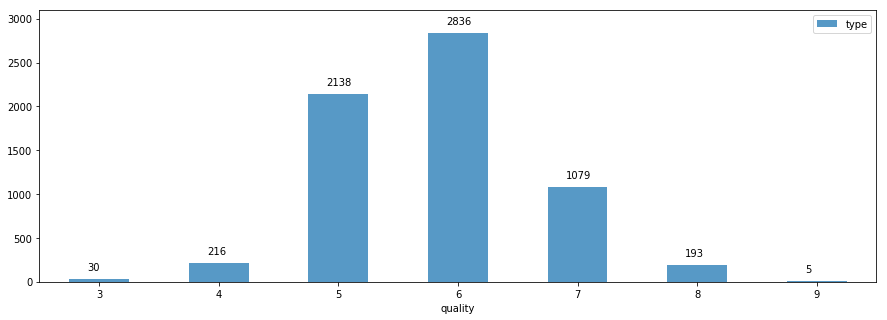

In [5]:
grouped_df = df.groupby('quality').agg({'type':'count'}).reset_index()

# plt.figure(figsize=(15,5))
ax = grouped_df.plot.bar(x='quality', figsize=(15,5), alpha=0.75, rot=0, ylim=(0,3100))
x_offset = -0.1
y_offset = 100
for p in ax.patches:
    b = p.get_bbox()
    val = "{}".format(int(b.y1 + b.y0))        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

In [4]:
df['quality_updated'] = df['quality'].apply(lambda x: "Bad" if x < 6 else "Good")
df['quality_encoded'] = df['quality_updated'].apply(lambda x: 0 if x == "Bad" else 1)

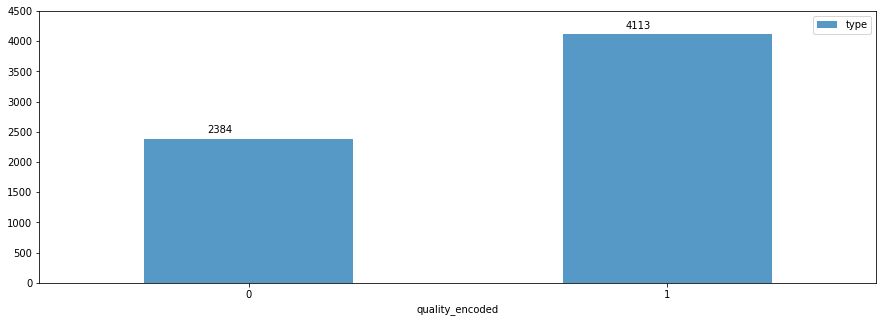

In [5]:
grouped_df = df.groupby('quality_encoded').agg({'type':'count'}).reset_index()

# plt.figure(figsize=(15,5))
ax = grouped_df.plot.bar(x='quality_encoded', figsize=(15,5), alpha=0.75, rot=0, ylim=(0,4500))
x_offset = -0.1
y_offset = 100
for p in ax.patches:
    b = p.get_bbox()
    val = "{}".format(int(b.y1 + b.y0))        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

### Explorando variáveis categóricas

O código abaixo mostra que a variável `type` contém apenas dois valores possíveis: _White_ e _Red_. É possível notar também que 75% dos exemplos são de vinhos branco e os demais de vinho tinto. 

In [6]:
df_grouped = df.groupby('type').agg({'quality': 'count'}).reset_index().rename(columns={"quality": 'type_count'})
df_grouped['type_perc'] = (df_grouped['type_count']*100/df_grouped['type_count'].sum())
df_grouped.head()

,type,type_count,type_perc
0,Red,1599,24.611359
1,White,4898,75.388641


### Explorando variáveis numéricas

O código abaixo apresenta um resumo das variáveis numéricas do dataset. É importante notar que elas não estão na mesma escala, como é o caso das variáveis `volatile_acidity`, que possui valores entre 0.08 e 1.5, e `total_sulfur_dioxide`, que possui valores entre 6.0 e 44.0. Outro ponto interessante a ser notado é que algumas variáveis parecem ter _outliers_, tais como `total_sulfur_dioxide` e `free_sulfur_dioxide`, cujos valores máximos são muito superiores ao percentil de 99% (foi feito o histograma dessas duas variávels a título de exemplo). 

Uma consequência interessante dessas observações é que teremos de fazer transformações nos dados para que estejam na mesma escala. Essa atividade será feita mais adiante na etapa de pré processamento dos dados. 

In [16]:
numeric_cols = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", 
                "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "ph", "sulphates"]

df[numeric_cols].describe(percentiles=[.25, .5, .75, .99])

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,1.710882,3.218501,0.531268
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,7.636088,0.160787,0.148806
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000
99%,12.000000,0.880000,0.740000,18.200000,0.186160,77.000000,238.000000,10.008000,3.640000,0.990000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,103.898000,4.010000,2.000000


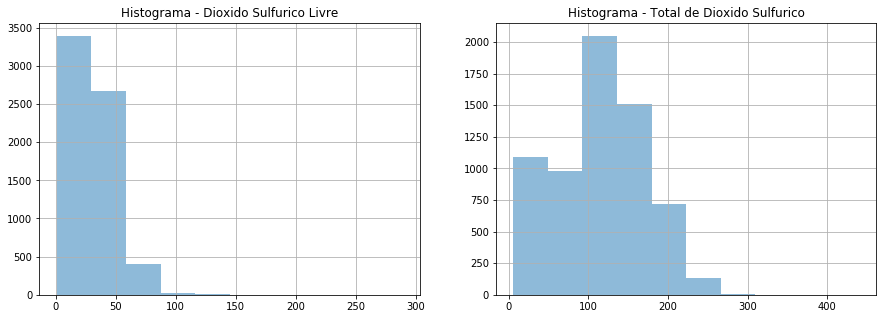

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

df['free_sulfur_dioxide'].hist(alpha=.5, ax=axes[0])
axes[0].set_title('Histograma - Dioxido Sulfurico Livre')
df['total_sulfur_dioxide'].hist(alpha=.5, ax=axes[1])
axes[1].set_title('Histograma - Total de Dioxido Sulfurico')
plt.show()

### O caso da variável alcohol

Como citado anteriormente, a variável `alcohol` foi identificada pelo Pandas como `object` porém ela deveria ser `float64` (numérica). O código abaixo mostra que existem alguns valores anômalos no dataset, provavelmente advindos de medições inadequadas. Também é possível notar que os exemplos com dados equivocados correspondem a apenas 0,6% do todo. Para lidar com essa situação, iremos remover as linhas em que `alcohol_numeric == NaN`. 

In [5]:
df['alcohol_numeric'] = pd.to_numeric(df['alcohol'], errors='coerce')

In [6]:
df.loc[df['alcohol_numeric'].isnull(), ['alcohol', 'alcohol_numeric']].head(10)

,alcohol,alcohol_numeric
4315,128.933.333.333.333,NaN
4319,128.933.333.333.333,NaN
4323,114.666.666.666.667,NaN
4341,100.333.333.333.333,NaN
4353,114.333.333.333.333,NaN
4356,105.333.333.333.333,NaN
4358,953.333.333.333.333,NaN
4364,109.333.333.333.333,NaN
4369,109.333.333.333.333,NaN
4372,113.666.666.666.667,NaN


In [7]:
df.loc[df['alcohol_numeric'].notnull(), ['alcohol', 'alcohol_numeric']].head()

,alcohol,alcohol_numeric
0,8.8,8.8
1,9.5,9.5
2,10.1,10.1
3,9.9,9.9
4,9.9,9.9


In [8]:
errors_count = (df[df['alcohol_numeric'].isnull()].shape[0]*100)/df.shape[0]

print("Apenas {:2f}% das linhas contem dados inadequados de teor alcoolico".format(errors_count))

Apenas 0.615669% das linhas contem dados inadequados de teor alcoolico


In [9]:
df = df[df['alcohol_numeric'].notnull()]

## Relação entre as variáveis

Nesta seção vamos identificar como as variáveis preditoras se relacionam com a variável de destino (`quality`). Usaremos algns testes estatísticos para isso. Como `quality` é categórica, precisamos utilizar técnicas adequadas para este cenário: aplicaremos o teste Chi quadrado para variáveis categóricas e correlação de Spearman para as variáveis numéricas.

### Correlação para variáveis categóricas

O teste de independência do chi quadrado avalia de suas variáveis categóricas são relacionadas em uma população. Sua hipótese nula é de que as duas variáveis são independentes. Vamos aplicar o teste para as variáveis `type` e `quality_encoded` e usar o nível de significância de 0.05. É possível observar uma explicação básica deste neste em [[1]](#references)

Como pode ser visto no código abaixo, o p-value do teste é $3,99 \times 10^{-21}$, o que significa que devemos rejeitar a hipótese nula de que a variável `type_encoded` é independente da variável `quality_encoded`. Isso é um indicativo de que devemos manter a variável `type_encoded` no modelo.

In [10]:
def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(chi2_contingency(ctsum.fillna(0)))

In [11]:
df['type_encoded'] = df['type'].apply(lambda x: 1 if x == "Red" else 2)

In [12]:
chi2, p_value, dof, expected =  chisq_of_df_cols(df, 'type_encoded', 'quality_encoded')

print("p-value is: {}".format(p_value))

p-value is: 3.99662160315e-21


### Correlação para variáveis numéricas

Diferente da correlação de Pearson, adequada para comparação entre duas variáveis contínuas e com uma relação linear, a correlação de Spearman é adequada para variáveis ordinais e contínuas e avalia com que intensidade a relação entre duas variáveis pode ser descrita pelo uso de uma função monótona [[2]](#references). É possível observar uma explicação básica deste neste em [[3]](#references). 

O código abaixo cria uma matriz de correlação entre todas as variáveis numéricas e a variável output do dataset. A parte importante a ser observada é a última linha, que contém a correlação entre `quality_encoded` e todas as demais variáveis. Nela é possível notar alguns pontos:

* A variável álcool (`alcohol_numeric`) tem a maior correlação com `quality`. Densidade (`density`), cloretos (`chlorides`) e acidez volátil (`volatile_acidity`) também possuem correlação alta com `quality_encoded` porém são negativas, o que indica que são inversamente proporcionais
* A variável açúcar residual (`residual_sugar`) tem a menor correlação e ela também é negativa, o que indica que as variáveis são inversamente proporcionais. O açúcar residual também é a variável que tem correlação mais próxima de zero entre todas, o que é um indicativo de que podemos retirá-la do modelo que criaremos. 
* As variáveis que tem relação com dióxido sulfúrico, `free_sulfur_dioxide` e `total_sulfur_dioxide`, tem correlações baixas e de sinal oposto. Elas também são a segunda e terceira menores correlações, o que indica que também podemos retirá-las do modelo que criaremos. 

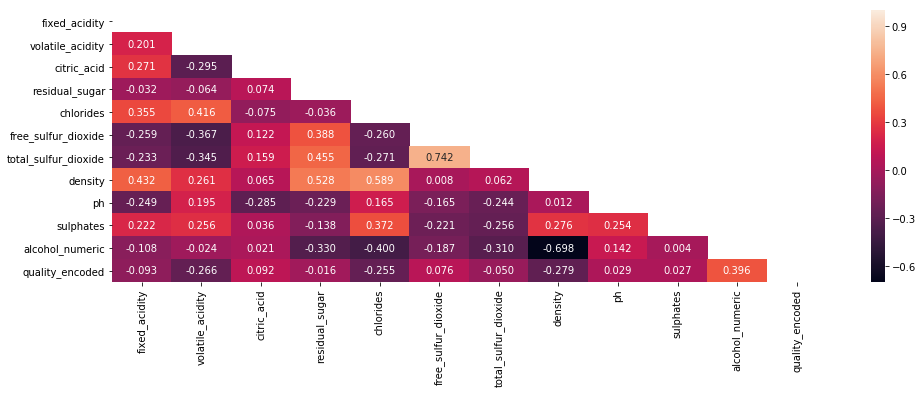

In [14]:
numeric_cols = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", 
                "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "ph", "sulphates", "alcohol_numeric"]
output_col = ["quality_encoded"]

plt.figure(figsize=(16,5))
corr = df[numeric_cols+output_col].corr(method="spearman")
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True, fmt= '.3f')
plt.show()

## Pré processamento dos dados

A partir das observações expostas na seção de análise exploratória dos dados nota-se que as variáveis numéricas estão em escalas diferentes, o que pode impactar no resultado dos modelos a ser criados. O código abaixo faz a normalização dos dados (mesmo procedimento do _Standard Scaler_ [[4]](#references) do sklearn). 

Outra atividade de pré-processamento que seria necessário é a transformação da variável `type` de string para número e, porém isso já foi realizado acima (criou-se a variável `type_encoded`). 

In [13]:
suffix = "_scaled"
numeric_cols = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", 
                "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "ph", "sulphates", "alcohol_numeric"]

for col in numeric_cols:
    df[col+suffix] = (df[col]-df[col].mean())/df[col].std()

In [14]:
df[[c for c in df.columns if "_scaled" in c]].head()

,fixed_acidity_scaled,volatile_acidity_scaled,citric_acid_scaled,residual_sugar_scaled,chlorides_scaled,free_sulfur_dioxide_scaled,total_sulfur_dioxide_scaled,density_scaled,ph_scaled,sulphates_scaled,alcohol_numeric_scaled
0,-0.169490,-0.423124,0.283184,3.201730,-0.315616,0.816828,0.959608,-0.093261,-1.359021,-0.545236,-1.415875
1,-0.710068,-0.240963,0.145733,-0.807247,-0.201689,-0.928962,0.288173,-0.094174,0.506124,-0.276545,-0.829100
2,0.679989,-0.362403,0.558088,0.305192,-0.173207,-0.027909,-0.330254,-0.094031,0.257438,-0.612408,-0.326149
3,-0.015040,-0.666005,0.008281,0.641022,0.054648,0.929459,1.242317,-0.093966,-0.177762,-0.881099,-0.493799
4,-0.015040,-0.666005,0.008281,0.641022,0.054648,0.929459,1.242317,-0.093966,-0.177762,-0.881099,-0.493799


### Ponto de atenção com a variável categórica

Ao utilizar implementações computacionais dos algoritmos de classificação, temos que transformar as variáveis categóricas que estão em formato de string para um valor numérico. Porém, é difícil encontrar um valor numérico que possa representá adequadamente essas variáveis no dataset. Por exemplo, quando criamos a coluna `type_encoded` acima, atribuímos o valor `1` para vinho tinto e `2` para vinho branco, mas isso não significa que esses números tenham algum tipo de "representação de valor", ou seja, não temos como dizer que `1` está próximo de "vinho tinho". 
Para lidar com essa questão, vamos listar duas opções sugeridas na literatura científica:

* **1-of-K Coding**: consiste em transformar todas as variáveis categóricas em dummy vars. Esse método, apesar de ter resultados satisfatórios, aumenta drasticamente o número de variáveis presentes no dataset o que pode prejudicar a performance do algoritmo e também gerar overfitting. É possível ver uma descrição da técnica em [[5]](#references) (o artigo fala de _clustering_, mas a técnica pode ser usada em situações de aprendizado supervisionado também).
* **Two-step Method for Clustering Mixed numeric and categorical data (TMCM)** [[6]](#references): o algoritmo foi desenvolvido para conseguir lidar com variáveis categóricas e numéricas simultaneamente na clusterização. Ele é dividido em duas etapas principais: a primeira é a manipulação de variáveis categóricas de acordo com a teoria de co-ocorrência, que analisa o relacionamento entre as variáveis categóricas e gera um valor numérico razoável (e não binário) para elas; a segunda consiste na aplicação do K-means em duas etapas. Nesse estudo, foi feita a implementação da primeira etapa do algoritmo e o código pode ser encontrado no arquivo `tmcm_feature_engineering.py`. 

In [15]:
suffix = "_scaled"
numeric_cols = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", 
                "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "ph", "sulphates", "alcohol_numeric"]
numeric_cols = [c+suffix for c in numeric_cols]
categorical_cols = ['type']

obj = TMCMFeatureEng(df=df, categ_cols=categorical_cols, numeric_cols=numeric_cols)
df = obj.transform()

In [16]:
df.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,...,citric_acid_scaled,residual_sugar_scaled,chlorides_scaled,free_sulfur_dioxide_scaled,total_sulfur_dioxide_scaled,density_scaled,ph_scaled,sulphates_scaled,alcohol_numeric_scaled,type_tmcm
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,...,0.283184,3.201730,-0.315616,0.816828,0.959608,-0.093261,-1.359021,-0.545236,-1.415875,0.401024
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,...,0.145733,-0.807247,-0.201689,-0.928962,0.288173,-0.094174,0.506124,-0.276545,-0.829100,0.401024
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,...,0.558088,0.305192,-0.173207,-0.027909,-0.330254,-0.094031,0.257438,-0.612408,-0.326149,0.401024
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,...,0.008281,0.641022,0.054648,0.929459,1.242317,-0.093966,-0.177762,-0.881099,-0.493799,0.401024
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,...,0.008281,0.641022,0.054648,0.929459,1.242317,-0.093966,-0.177762,-0.881099,-0.493799,0.401024


## Implementação do modelo

Utilizaremos o modelo de árvores de decisão para resolver este desafio. Ele é um modelo não paramétrico de classificação e que aprende algumas regras de decisão a partir dos dados inputados no mesmo. Entre suas vantagens estão:

* Facilidade de interpretação (é possível explicar cenários usando lógica booleana)
* Capaz de lidar com um problema de multi classes como o deste desafio

Um grande trade-off desse modelo é a possibilidade de criar árvores demasiadamente complexas e que podem criar _overfitting_. Para evitar que isso aconteça, vamos desenhar as curvas de aprendizado de diferentes árvores treinadas e variando a altura da mesma (`max_depth`). 

Ademais, usaremos **_information gain_** como métrica de custo na criação da árvore. Basicamente ela usa o decaimento da entropia (medida de homogeneidade de um conjunto de dados) para selecionar a melhor quebra dos dados em uma _feature_. Como métrica de avaliação da qualidade do modelo, usaremos como **métrica principal  a acurácia**, que nos indicará o percentual dos exemplos que classificamos corretamente, e também usaremos as **métricas de precisão e _recall_ como secundárias** a fim de identificar potenciais viéses do modelo. 

### Seleção de features

Vamos listar abaixo algumas formas de selecionar as melhores features para o modelo:

* Conhecimento de contexto: consiste em usar o conhecimento de negócio existente para remover _features_ que não sejam relevantes ou que não possam ser usadas por questões como regulamentação ou estratégia de negócio. 
* Métodos de filtragem: são usados geralmente como etapas de pré processamento dos dados e não dependem de algoritmos de aprendizado de máquina específicos. As _features_ são selecionadas a partir de testes estatísticos relevantes.
* Métodos _wrapper_: consiste em usar um subconjunto de _features_ para treinar e testar o modelo e, dependendo dos resultados deste modelo, é decidido pela adição ou remoção das _features_. Basicamente se trata de um problema de busca.

Neste problema, usaremos os testes estatísticos das seções anteriores para decidir que _features_ remover. A partir do que foi exposto na seção de anális exploratória, vimos que a variável `residual_sugar` tem um correlação muito baixa com qualidade (próxima de zero), logo não a usaremos em nosso modelo. 

O código abaixo seleciona apenas as _features_ relevantes para o modelo.

In [17]:
features_cols = [c for c in df.columns if "_scaled" in c and "residual_sugar" not in c] + ["type_tmcm"]
output_col = 'quality_encoded'

X = df[features_cols]
y = df[output_col]

### Tratando desbalanceamento

Como citado anteriormente, as classes do dataset estão muito desbalanceadas. Para que o modelo respeite isso precisamos fazer a divisão dos dados em treino e teste de acordo com essa proporção entre as classes. Para isso, o sk-learn oferece o atributo `stratify`, que faz essa segmentação. 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y)

### Modelo na prática

A partir das curvas de aprendizado abaixo percebe-se que os modelos com `max_depth > 10` começar a ter comportamento de _overfitting_, pois as curvas perdem sua convergência. Por outro lado, os modelos com `max_depth <= 7` apresentar bons resultados com número menor de amostras, com uma atenção especial para `max_depth = 7`, que demora mais para ter uma convergência, porém se estabiliza em torno de `0.8`. 

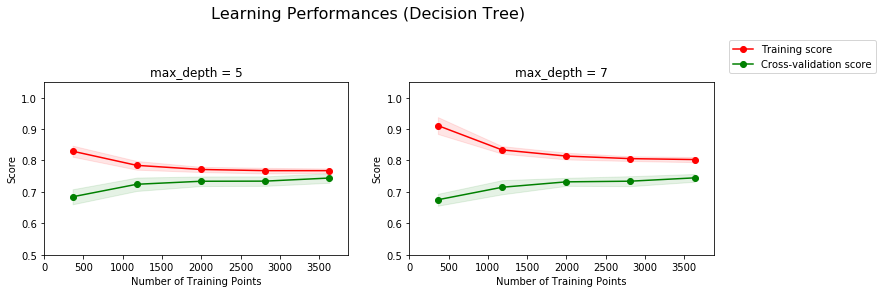

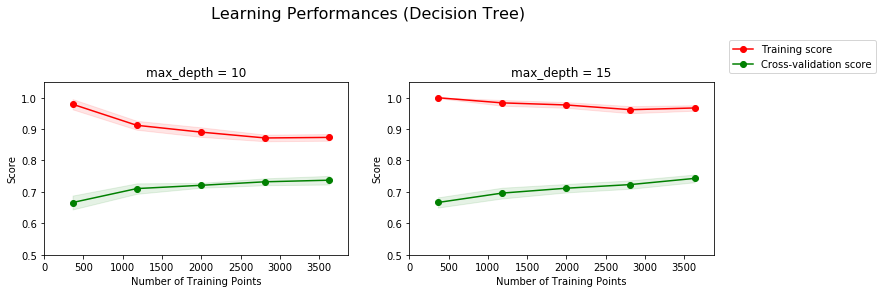

In [19]:
title = "Learning Performances (Decision Tree)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 25% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

helper.plot_learning_curve(title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4, max_depths=[5, 7], 
                           subset=False, scoring_metric='accuracy')
helper.plot_learning_curve(title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4, max_depths=[10, 15], 
                           subset=False, scoring_metric='accuracy')

A partir das curvas de aprendizado não fica claro qual o melhor valor para o parâmetro `max_depth` que otimiza os resultados do modelo. Para responder essa questão o gráfico com as curvas de validação foi desenhado abaixo. A partir do mesmo, percebe-se que o valor mais adequado é `5`, pois a partir desse ponto o modelo começa a ter overfitting o que pode ser percebido pela queda na acurácia da curva de validação. 

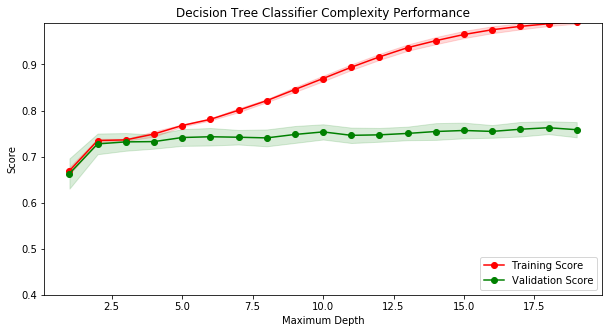

In [20]:
helper.plot_model_complexity(X_train, y_train)

Agora, o código abaixo realiza a implementação do modelo com os parâmetros adequados e obtém uma **acurácia de 75%**. Ao observar a matriz de confusão, nota-se que o modelo é, de certa forma, otimista em relação a qualidade do vinho, pois classifica a maioria como positivo. Isso também pode ser efeito do desbalanceamento do dataset. 

A **precisão do modelo, 85%** e o **recall do mesmo, 78%**, corroboram com as observações anteriores e indicam que o modelo é bom para identificar vinhos da categoria _Good_. Por fim, temos um valor bom de **AUC, 0.81**, que também atesta a boa qualidade do modelo desenvolvido. 

In [19]:
clf = tree.DecisionTreeClassifier(max_depth=5, criterion="entropy")
clf = clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)

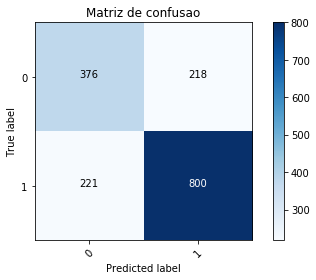

In [21]:
cnf_matrix = confusion_matrix(y_test, y_pred)
helper.plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Matriz de confusao')

ROC AUC: 0.81


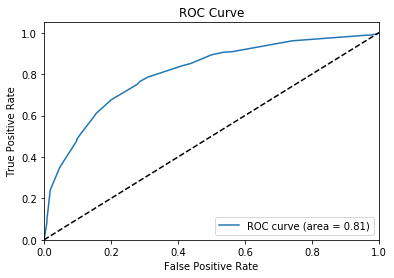

Acurácia do modelo: 0.750464396285
Precisão do modelo: 0.813387423935
Recall do modelo: 0.785504407444


In [21]:
helper.plot_roc_curve(y_test, y_pred_proba)

print("Acurácia do modelo: {}".format(accuracy_score(y_test, y_pred)))
print("Precisão do modelo: {}".format(precision_score(y_test, y_pred)))
print("Recall do modelo: {}".format(recall_score(y_test, y_pred)))

## Features mais relevantes

Uma das vantagens do algoritmo de árvore de decisão é que ele faz o rankeamento das features mais importantes de acordo com o information gain relacionado a elas. O código abaixo mostra as 5 features mais relevantes para o modelo bem como o valor de sua importância. 

É interessante notar que a variável `free_sulfur_dioxide_scaled`, que apresentou baixa correlação com a variável `quality_encoded` quando avaliada na seção de Análise Exploratória, é a quarta _feature_ mais importante do modelo e anteriormente a identificamos como candidata a ser removida. 

In [32]:
importance_dict = {}
for name, importance in zip(X.columns, clf.feature_importances_):
    importance_dict[name] = importance

for w in sorted(importance_dict, key=importance_dict.get, reverse=True)[0:5]:
    print("Feature: {:30} => Importância: {:4.2f}".format(w, importance_dict[w]))

Feature: alcohol_numeric_scaled         => Importância: 0.55
Feature: volatile_acidity_scaled        => Importância: 0.25
Feature: sulphates_scaled               => Importância: 0.08
Feature: free_sulfur_dioxide_scaled     => Importância: 0.05
Feature: ph_scaled                      => Importância: 0.03


## Variantes da resolução

Nesta seção vamos explorar três variações na solução proposta e observaremos como a métrica principal e as secundárias reagem. Estas variações são:

* Usar método automatizado de _feature selection_
* Aplicar _undersampling_ para tratar desbalaceamento de classes
* Usar outro algoritmo de classificação

### Método automatizado de _feature selection_

Usaremos o método `SelectKBest` presente no sk-learn e vamos escolher `k=7` arbitrariamente neste estudo. Esse método usa por padrão o **teste ANOVA F-value** (`f_classif`) para selecionar as melhores variáveis. Ele examina se, quando nós agrupamos uma _feature_ numérica de acordo com a variável de destino, as médias de cada grupo são significativamente diferentes.

A curva de complexidade mostra que o melhor valor de `max_depth` é 5. Após implementação do modelo nota-se que houve uma diminuição nos valores de acurácia e precisão mas o _recall_ aumentou levemente. Uma possível melhoria no mesmo é variar os valores de `k` para selecionar diferentes quantidades de _features_.

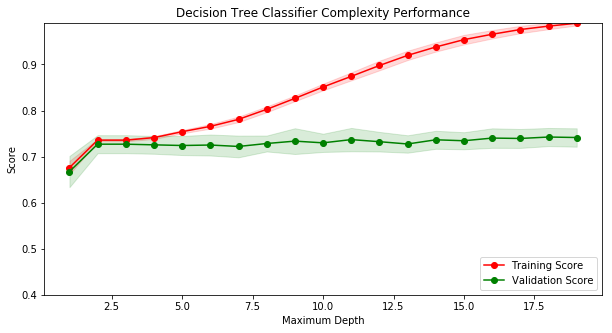

In [36]:
features_cols = [c for c in df.columns if "_scaled" in c] + ["type_tmcm"]
output_col = 'quality_encoded'

X = df[features_cols]
y = df[output_col]

selector = SelectKBest(f_classif, k=7)
X_new = selector.fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=.25, stratify=y)
helper.plot_model_complexity(X_train, y_train)

In [37]:
clf = tree.DecisionTreeClassifier(max_depth=5, criterion="entropy")
clf = clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)

print("Acurácia do modelo: {}".format(accuracy_score(y_test, y_pred)))
print("Precisão do modelo: {}".format(precision_score(y_test, y_pred)))
print("Recall do modelo: {}".format(recall_score(y_test, y_pred)))

Acurácia do modelo: 0.724458204334
Precisão do modelo: 0.767657992565
Recall do modelo: 0.809010773751


### Undersampling na classe _Good_

O código abaixo reduz a quantidade de exemplos de vinhos bons para que se assemelhe aos ruins. O resultado apresentado abaixo mostra que o _recall_ do modelo foi bastante reduzido através desse método. Isso pode ser um efeito aleatório da segmentação dos dados em treino e teste. Mas é relevante citar que a acurácia diminuiu, mas não de forma significativa, o que mostra que o desbalanceamento do dataset não é um fator chave para aumentarmos a precisão do modelo. 

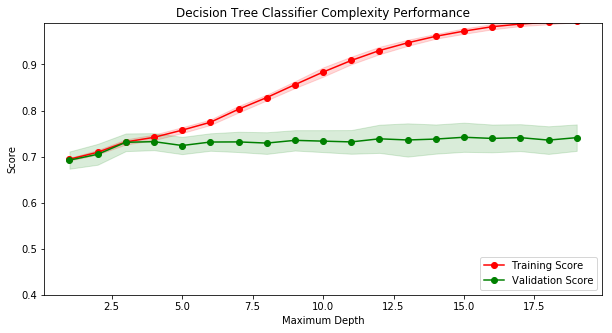

In [47]:
neg_cases = df[df["quality_encoded"] == 0]
pos_cases = df[df["quality_encoded"] == 1]

pos_cases = pos_cases.sample(n=neg_cases.shape[0])

df_new = pd.concat([neg_cases, pos_cases])

features_cols = [c for c in df_new.columns if "_scaled" in c] + ["type_tmcm"]
output_col = 'quality_encoded'

X = df_new[features_cols]
y = df_new[output_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
helper.plot_model_complexity(X_train, y_train)

In [48]:
clf = tree.DecisionTreeClassifier(max_depth=5, criterion="entropy")
clf = clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)

print("Acurácia do modelo: {}".format(accuracy_score(y_test, y_pred)))
print("Precisão do modelo: {}".format(precision_score(y_test, y_pred)))
print("Recall do modelo: {}".format(recall_score(y_test, y_pred)))

Acurácia do modelo: 0.713804713805
Precisão do modelo: 0.762295081967
Recall do modelo: 0.624161073826


### Aplicando outro algoritmo

Escolhemos o algoritmo _Support Vector Machines_, que divide os dados utilizando o melhor hiperplano possível e tem como âncoras para definição deste os _support vectors_, que são os pontos mais próximos ao plano. É um algoritmo muito poderoso mas, por ser paramétrico, precisaremos usar o _GridSearch_ para determinar quais os melhores valores de `C`, `kernel` e `gamma` do modelo. 

O código abaixo mostra que o modelo conseguiu elevar significativamente o _recall_ da classificação, apesar de não alterar muito o valor da acurácia. Já a precisão se manteve semelhante à vista nas demais variantes. 

In [50]:
features_cols = [c for c in df.columns if "_scaled" in c and "residual_sugar" not in c] + ["type_tmcm"]
output_col = 'quality_encoded'

X = df[features_cols]
y = df[output_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y)

param_grid = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear', 'rbf'], 'gamma': [0.001, 0.0001]},
]
svc = SVC()
clf = GridSearchCV(svc, param_grid, cv=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Acurácia do modelo: {}".format(accuracy_score(y_test, y_pred)))
print("Precisão do modelo: {}".format(precision_score(y_test, y_pred)))
print("Recall do modelo: {}".format(recall_score(y_test, y_pred)))

Acurácia do modelo: 0.741176470588
Precisão do modelo: 0.766107678729
Recall do modelo: 0.850146914789


## Conclusões

Neste projeto foi implementado um modelo de árvore de decisão para predizer a qualidade de vinhos. A qualidade dos vinhos apresentou uma distribuição normal e também continha pouquíssimos exemplos com qualidade muito boa ou muito ruim. Para lidar com isso, optou-se por tornar o problema numa classificação binária. 

Também usamos uma técnica baseada na teoria de co-ocorrência para criar valores numéricos apropriados para _features_ categóricas do dataset. Implementamos um modelo de árvore de decisão que apresentou acurácia de cerca de 75%. Por fim, exploramos algumas variantes da solução proposta para averiguar se as métricas dos modelos melhorariam.

Para trabalhos futuros, vislumbram-se as seguintes possibilidades:

* Explorar outros algoritmos de classificação
* Aplicar a técnica de 1-of-K Coding para lidar com a variável categórica `type`
* Utilizar a técnica de _oversampling_ para tratar melhor os dados
* Tentar adquirir mais dados amostras para o dataset, principalmente de vinhos muito bons e muito ruins para que, a partir deles seja possível desenvolver um classificador multi-classe confiável. 

## [Referências](#references)

[1] How to calculate Chi Square Test for Independence (two way) - https://www.youtube.com/watch?v=xEiQn6sGM20

[2] Correlação de postos de Spearman - https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_de_postos_de_Spearman

[3] Spearman Correlation - https://www.youtube.com/watch?v=YpG2MlulP_o

[4] Standard Scaler - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

[5] Wang, Fei & Franco, Hector & Pugh, John & Ross, Robert. (2016). Empirical Comparative Analysis of 1-of-K Coding and K-Prototypes in Categorical Clustering.

[6] A Two-Step Method for Clustering Mixed Categroical and Numeric Data